In [1]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
import scipy.optimize as optimize
from uncertainties import ufloat

%matplotlib inline

plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 16
plt.style.use('ggplot')

In [2]:
DataStructure = namedtuple('DataStructure', 'hopg_down hopg_up au_1 au_2')
data = DataStructure(
    hopg_down = {
        'file': './raw/HOPG-DOWN.txt',
        'dim': np.linspace(0, 2, 100),
        'title': 'HOPG downwards',
    },
    hopg_up = {
        'file': './raw/HOPG-UP.txt',
        'dim': np.linspace(0, 2, 100),
        'title': 'HOPG upwards',
    },
    au_1 = {
        'file': './raw/AU-1-1.txt',
        'dim': np.linspace(0, 300, 512),
        'title': '1. AU',
    },
    au_2 = {
        'file': './raw/AU-2-2.txt',
        'dim': np.linspace(0, 300, 512),
        'title': '2. AU',
    }
)

In [3]:
for obj in data:
    im_data = np.genfromtxt(obj['file'])
    im_data = np.flipud(im_data)
    obj['data'] = im_data

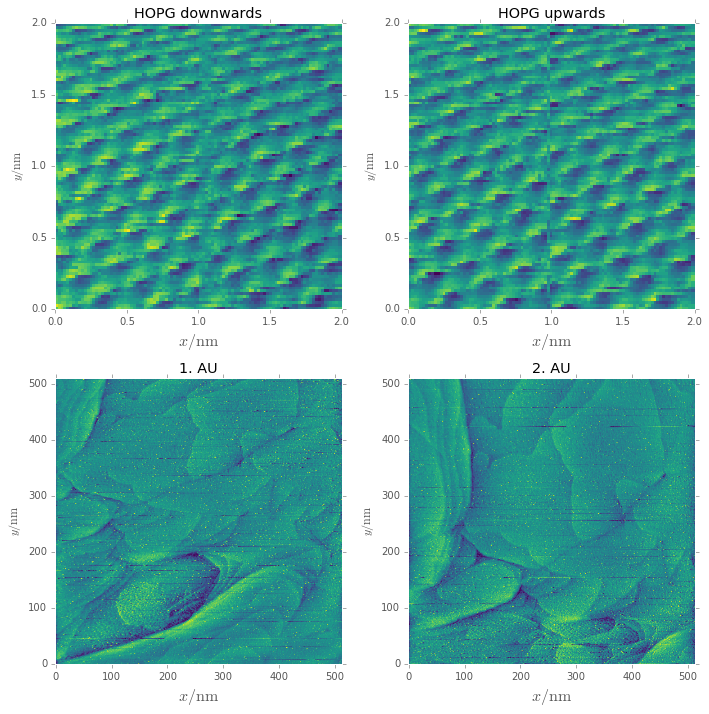

In [4]:
plt.figure(figsize=(10, 10))
for i, obj in enumerate(data):
    ax = plt.subplot(220 + i + 1, aspect='equal')
    if(obj['dim'].size > 200):
        plt.imshow(obj['data'], origin='lower')
        plt.grid(b=False)
    else:
        plt.pcolormesh(obj['dim'], obj['dim'], obj['data'])
    plt.title(obj['title'])
    plt.xlabel(r'$x / \mathrm{nm}$', fontsize=16)
    plt.ylabel(r'$y / \mathrm{nm}$')
plt.tight_layout()
plt.savefig('build/plots/all_plots.pdf')
plt.show()

In [5]:
def linear_func(x, a, b):
    return np.array(a) * x + b

In [6]:
upper_bound1 = [2, -0.7]
lower_bound1 = [2, -1]
upper_bound2 = [-0.85, 1.4]
lower_bound2 = [-0.85, 1.2]

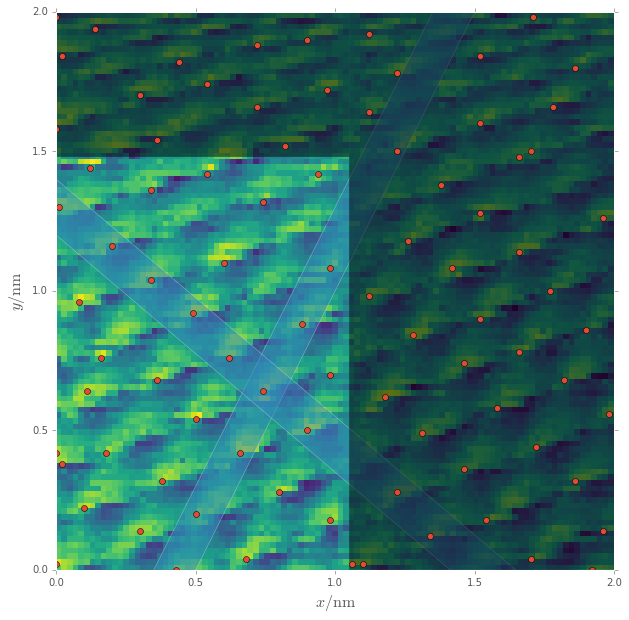

In [7]:
# took this from http://stackoverflow.com/a/9113227

neighbourhood_size = 12
threshhold = 5e-15

ds = data.hopg_down['data']

d_maxima = filters.maximum_filter(ds, neighbourhood_size)
maxima = (ds == d_maxima)
d_min = filters.minimum_filter(ds, neighbourhood_size)
diff = ((d_maxima - d_min) > threshhold)
maxima[diff == 0] = 0

labeled, num_objects = ndimage.label(maxima)
slices = ndimage.find_objects(labeled)
x, y = [], []
for dy,dx in slices:
    x_center = (dx.start + dx.stop - 1)/100
    x.append(x_center)
    y_center = (dy.start + dy.stop - 1)/100  
    y.append(y_center)

plt.figure(figsize=(10, 10))
plt.pcolormesh(data.hopg_down['dim'], data.hopg_down['dim'], data.hopg_down['data'])
plt.plot(np.array(x), np.array(y), 'o')
plt.xlabel(r'$x/\mathrm{nm}$', fontsize=16)
plt.ylabel(r'$y/\mathrm{nm}$', fontsize=16)
plt.axis('equal')
plt.xlim(0, 2)
plt.ylim(0, 2)

xs = np.linspace(0, 2, 10000)
plt.fill_between(xs, linear_func(xs, *lower_bound1), linear_func(xs, *upper_bound1), alpha=0.5)
plt.fill_between(xs, linear_func(xs, *lower_bound2), linear_func(xs, *upper_bound2), alpha=0.5)
plt.fill_between(xs[xs < 1.05], 1.48, 2, alpha=0.5, edgecolor='none', facecolor='k')
plt.fill_betweenx(xs, 1.05, 2, alpha=0.5, edgecolor='none', facecolor='k')
plt.savefig('build/plots/hopg_down_selection.pdf')
plt.show()

[[0.091666666666666674, 0.17573765279383174], [0.12714285714285714, -0.11690802254710898]]


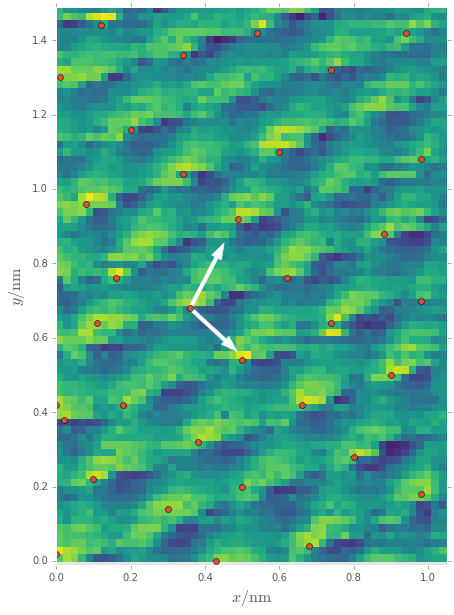

In [8]:
gvs = []

for u, l in [[upper_bound1, lower_bound1],
             [upper_bound2, lower_bound2]]:
    selection = (y < linear_func(x, *u)) & (y > linear_func(x, *l)) & (np.array(x) < 1.05)
    fit_xs = np.array(x)[selection]
    fit_ys = np.array(y)[selection]

    coeff, cov = optimize.curve_fit(linear_func, fit_xs, fit_ys)
    errs = np.sqrt(np.diag(cov))
    dx = (np.max(fit_xs) - np.min(fit_xs)) / len(fit_xs)
    gvs.append([dx, coeff[0] * dx])

print(gvs)

plt.figure(figsize=(7, 10))
plt.pcolormesh(data.hopg_down['dim'], data.hopg_down['dim'], data.hopg_down['data'])
plt.plot(np.array(x), np.array(y), 'o')
p = 32
for i in [0, 1]:
    plt.arrow(x[p], y[p], gvs[i][0], gvs[i][1], width=0.01, length_includes_head=True, head_width=0.03, fc='w')
# annotate with indices if neccessary
# for i, xy in enumerate(zip(x, y)):
#    plt.annotate(i, xy)
plt.xlabel(r'$x/\mathrm{nm}$', fontsize=16)
plt.ylabel(r'$y/\mathrm{nm}$', fontsize=16)
plt.axis('equal')
plt.xlim(0, 1.05)
plt.ylim(0, 1.48)
plt.savefig('build/plots/hopg_down_arrows.pdf')
plt.show()